In [1]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
from matplotlib import cm
import time
from numpy.random import default_rng

import healpy as hp
import pymaster as nmt
import pandas as pd

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations
import masks

In [2]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

In [3]:
rng = default_rng(seed=42)

# Load maps

In [4]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
print(NSIDE, NPIX)
area_per_pixel = hp.nside2pixarea(NSIDE, degrees=True)
print(f"Area per pixel: {area_per_pixel:.3f} deg")

64 49152
Area per pixel: 0.839 deg


In [5]:
fn_dustmap = f'../data/maps/map_dust_NSIDE{NSIDE}.npy'
map_dust = utils.get_dust_map(NSIDE=NSIDE, R=3.1, fn_map=fn_dustmap)

Dustmap already exists, loading from ../data/maps/map_dust_NSIDE64.npy


In [6]:
fn_starmap = f'../data/maps/map_stars_NSIDE{NSIDE}.npy'
map_stars = maps.get_star_map(NSIDE=NSIDE, fn_map=fn_starmap)
map_stardens = map_stars/area_per_pixel

Star map already exists, loading from ../data/maps/map_stars_NSIDE64.npy


In [7]:
fn_m10map = f'../data/maps/map_m10_NSIDE{NSIDE}.npy'
map_m10 = maps.get_m10_map(NSIDE=NSIDE, fn_map=fn_m10map)

Star map already exists, loading from ../data/maps/map_m10_NSIDE64.npy


# Plot maps

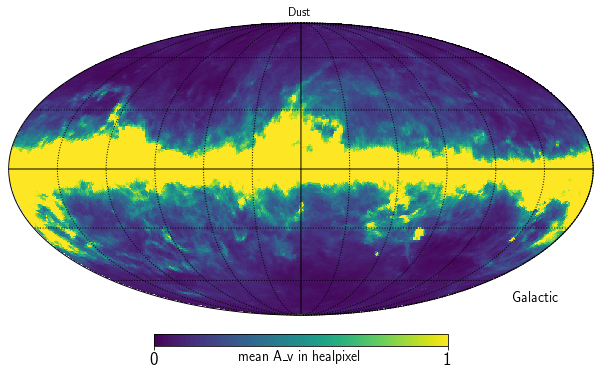

In [8]:
hp.mollview(map_dust, title=rf"Dust",
            unit=r"mean A_v in healpixel", cmap='viridis', coord=['C', 'G'], min=0, max=1)
hp.graticule()

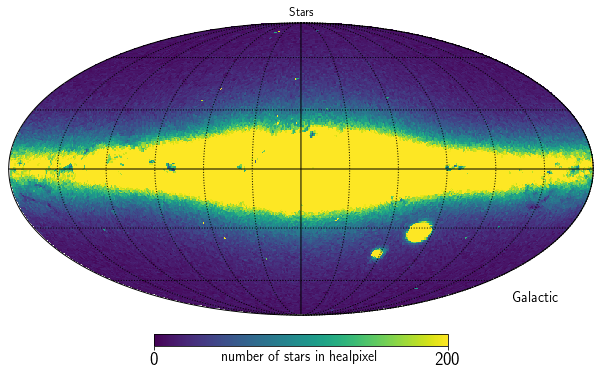

In [9]:
hp.mollview(map_stars, title=rf"Stars",
            unit=r"number of stars in healpixel", cmap='viridis', coord=['C', 'G'], min=0, max=200)
hp.graticule()

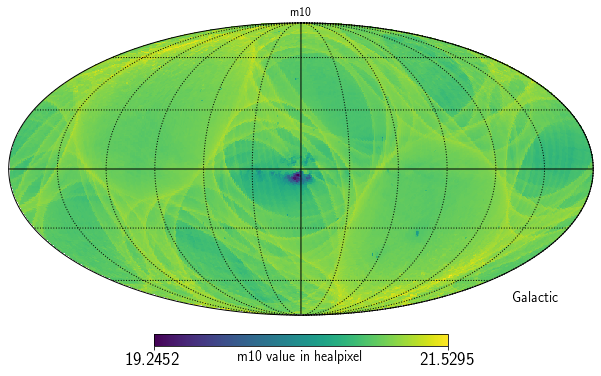

In [10]:
hp.mollview(map_m10, title=rf"m10",
            unit=r"m10 value in healpixel", cmap='viridis', coord=['C', 'G'])
hp.graticule()

# Load data

In [11]:
G_max = 20
n_max_map_dict = {20: 25, 20.2: 30, 20.4: 35}
n_max_map = n_max_map_dict[G_max]
fn_gaia = f'../data/gaia_G{G_max}.fits'
tab_gaia = utils.load_table(fn_gaia)
N_data = len(tab_gaia)
print(f"Number of data sources: {N_data}")

Number of data sources: 648842


In [12]:
map_nqso_data, pixel_indices_data = maps.get_map(NSIDE, tab_gaia['ra'], tab_gaia['dec'], null_val=0)

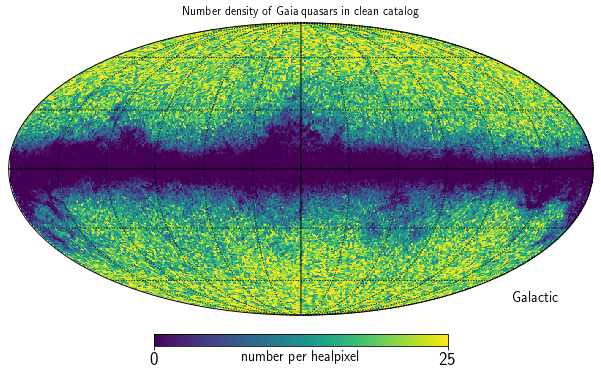

In [13]:
hp.mollview(map_nqso_data, title=rf"Number density of Gaia quasars in clean catalog",
            unit=r"number per healpixel", cmap='viridis', coord=['C', 'G'], min=0, max=n_max_map)
hp.graticule()

# Redshift dist

In [14]:
print(np.median(tab_gaia['redshift_spz']))
idx_highz = tab_gaia['redshift_spz'] > np.median(tab_gaia['redshift_spz'])

map_nqso_data_highz, _ = maps.get_map(NSIDE, tab_gaia['ra'][idx_highz], tab_gaia['dec'][idx_highz], null_val=0)

1.433341566268921


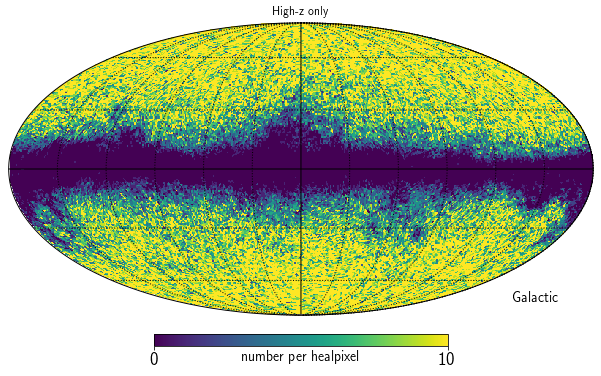

In [15]:
hp.mollview(map_nqso_data_highz, title=rf"High-z only",
            unit=r"number per healpixel", cmap='viridis', coord=['C', 'G'], min=0, max=10)
hp.graticule()

/state/partition1/job-23071491/ipykernel_1015037/1272591408.py:1: RuntimeWarning: invalid value encountered in true_divide
  hp.mollview(map_nqso_data_highz/map_nqso_data, title=rf"Ratio of high-z to all",


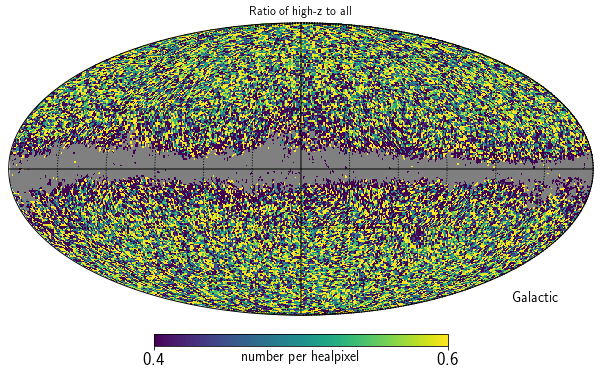

In [16]:
hp.mollview(map_nqso_data_highz/map_nqso_data, title=rf"Ratio of high-z to all",
            unit=r"number per healpixel", cmap='viridis', coord=['C', 'G'], min=0.4, max=0.6)
hp.graticule()

## MCs

In [17]:
mask_mcs = masks.magellanic_clouds_mask(NSIDE)

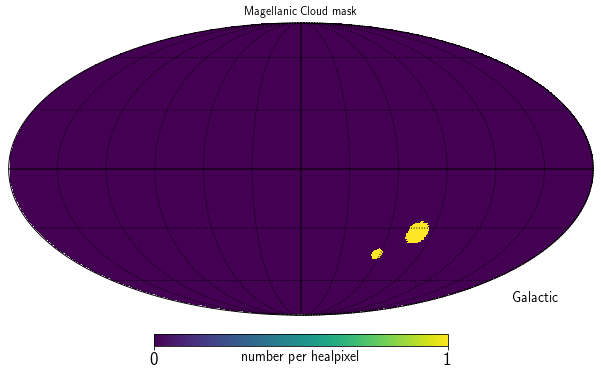

In [18]:
hp.mollview(mask_mcs, title=rf"Magellanic Cloud mask",
            unit=r"number per healpixel", cmap='viridis', coord=['C', 'G'])
hp.graticule()

In [19]:
idx_nomcs = ~mask_mcs

# Set up features

In [20]:
def f_dust(map_d):
    #return np.log(map_d)
    return map_d

In [21]:
def f_stars(map_s):
    return np.log(map_s)
    #return map_s

In [22]:
def f_m10(map_m):
    #return map_m - 20
    return map_m

In [23]:
feature_names = ['constant', r'$f_\mathrm{e}$(extinction)', 
                 r'$f_\mathrm{s}$(stellar number)', r'$f_\mathrm{m}$(m10)']
constant = np.ones(NPIX)
X_full = np.vstack((constant, f_dust(map_dust), f_stars(map_stars), f_m10(map_m10))).T
print(X_full.shape)

(49152, 4)


In [24]:
y_scale_name = 'log'
#y_scale_name = None

In [25]:
y_full = map_nqso_data

if y_scale_name=='log':
    idx_fit = y_full > 0 #hack
else:
    idx_fit = np.full(len(y_full), True)
    
#idx_fit = idx_fit & idx_nomcs
y_unscaled = y_full[idx_fit]
X_unscaled = X_full[idx_fit]

# print(np.sum((y_unscaled>0)))
# print(np.min(y_unscaled))
# idx_zero = y_unscaled < 1e-3
# print(np.sum(idx_zero), len(y_unscaled))
# y_unscaled[idx_zero] = 1
# print(np.min(y_unscaled))

print(y_unscaled.shape, X_unscaled.shape)

(42113,) (42113, 4)


In [26]:
def scale_X(X, scale_name='zeromean'):
    if scale_name=='minmax':
        mins = np.min(X[:,1:], axis=0)
        maxes = np.max(X[:,1:], axis=0)
        X[:,1:] = (X[:,1:] - mins)/(maxes-mins)
    if scale_name=='zeromean':
        X[:,1:] -= np.mean(X[:,1:], axis=0)
    return X

In [27]:
def scale_y(y, scale_name='log'):
    if scale_name=='log':
        return np.log(y)
    return y

def unscale_y(y_scaled, scale_name='log'):
    if scale_name=='log':
        return np.exp(y_scaled)
    return y_scaled

In [28]:
print(np.mean(X_unscaled, axis=0), np.std(X_unscaled, axis=0))
X = scale_X(X_unscaled)
print(np.mean(X, axis=0), np.std(X, axis=0))

[ 1.          0.31568819  3.66731482 21.03039924] [0.         0.61006006 1.20787498 0.10841953]
[ 1.00000000e+00  6.25339518e-15  3.10899903e-13 -1.28814870e-14] [0.         0.61006006 1.20787498 0.10841953]


In [29]:
label_name = 'number of QSOs'
if y_scale_name is not None:
    label_name = f'{y_scale_name}({label_name})'
    
y = scale_y(y_unscaled, scale_name=y_scale_name)

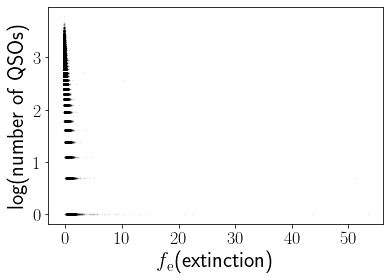

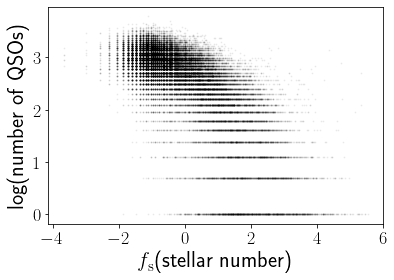

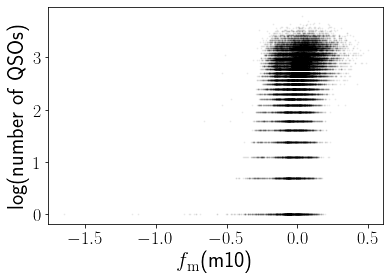

In [30]:
for j in range(1, X.shape[1]):
    plt.figure()
    plt.scatter(X[:,j], y, s=1, alpha=0.05, color='k')
    plt.xlabel(feature_names[j])
    plt.ylabel(label_name)

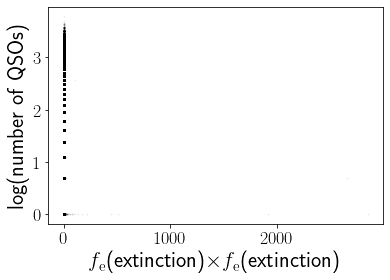

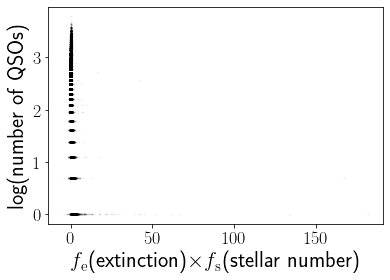

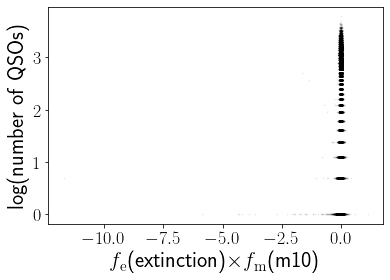

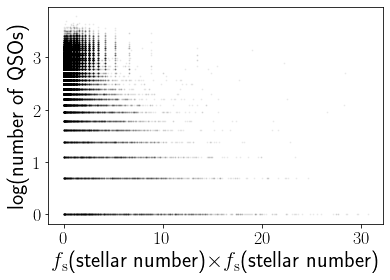

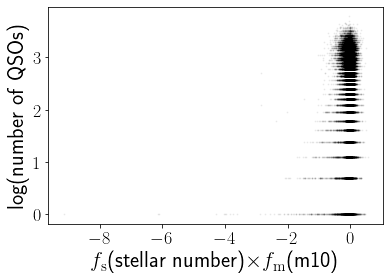

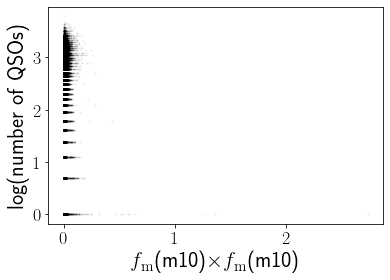

In [31]:
for i in range(1, X.shape[1]):
    for j in range(i, X.shape[1]):
        plt.figure()
        plt.scatter(X[:,i]*X[:,j], y, s=1, alpha=0.05, color='k')
        plt.xlabel(feature_names[i]+r'$\times$'+feature_names[j])
        plt.ylabel(label_name)

linear least squares: theta = (X.T * C^inv * X)^inv (X.T C^inv y)

In [32]:
# XTCinvX = X.T @ Cinv @ X
# XTCinvy = X.T @ Cinv @ y

In [33]:
# For now, assume C is the idendity and omit
XTCinvX = X.T @ X
XTCinvy = X.T @ y

In [34]:
res = np.linalg.lstsq(XTCinvX, XTCinvy, rcond=None)
theta = res[0]
print(theta)

[ 2.54519178 -0.3859606  -0.36110166 -0.0237611 ]


In [35]:
def calc_y_pred(X, theta):
    return X @ theta

In [36]:
y_pred = calc_y_pred(X, theta)
y_pred_unscaled = unscale_y(y_pred, scale_name=y_scale_name)

In [37]:
y_pred_full = np.zeros(y_full.shape)
y_pred_full[idx_fit] = y_pred

y_pred_full_unscaled = np.zeros(y_full.shape)
y_pred_full_unscaled[idx_fit] = y_pred_unscaled

### Check out predictions:

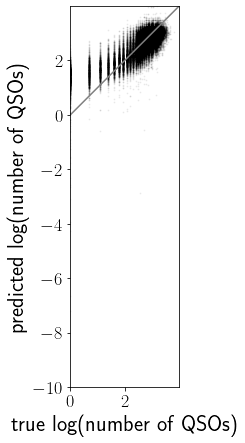

In [38]:
plt.figure(figsize=(7,7))
n_max = max(np.max(y), np.max(y_pred))
xx = np.linspace(0, n_max)
plt.plot(xx, xx, color='grey')
plt.scatter(y, y_pred, s=1, alpha=0.05, color='k')
plt.xlim(0,n_max)
plt.ylim(-10,n_max)
plt.xlabel('true '+label_name)
plt.ylabel('predicted '+label_name)
ax = plt.gca()
ax.set_aspect('equal')

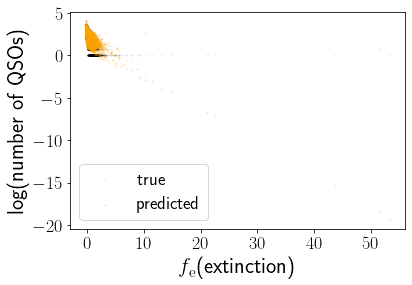

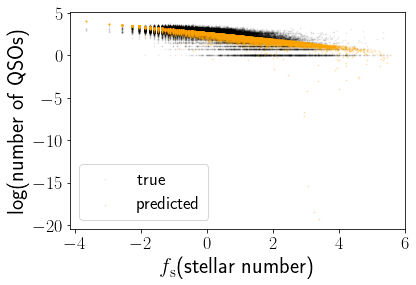

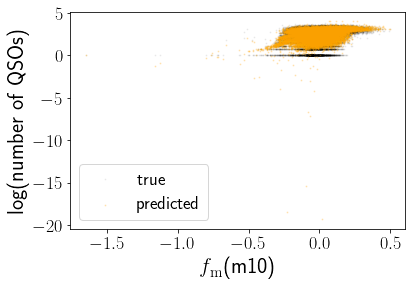

In [39]:
for j in range(1, X.shape[1]):
    plt.figure()
    plt.xlabel(feature_names[j])
    plt.ylabel(label_name)
    
    plt.scatter(X[:,j], y, s=1, alpha=0.05, color='k', label='true')
    plt.scatter(X[:,j], y_pred, color='orange', s=1, alpha=0.2, label='predicted')
    plt.legend()

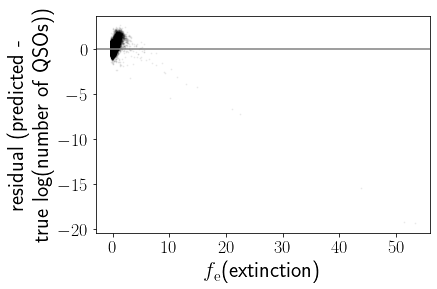

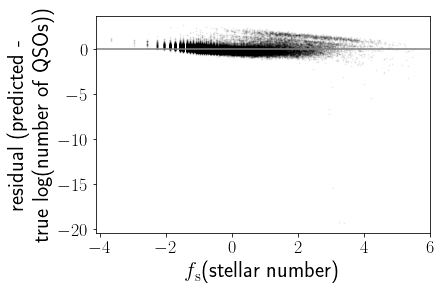

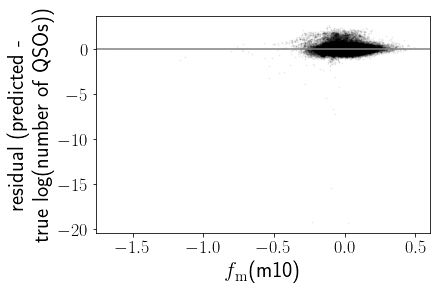

In [40]:
for j in range(1, X.shape[1]):
    plt.figure()
    plt.xlabel(feature_names[j])
    plt.ylabel(f'residual (predicted -\ntrue {label_name})')
    plt.axhline(0, color='grey')
    plt.scatter(X[:,j], y_pred-y, s=1, alpha=0.05, color='k', label='true')

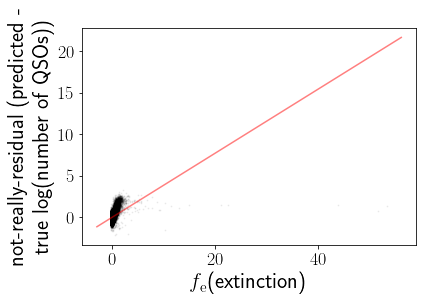

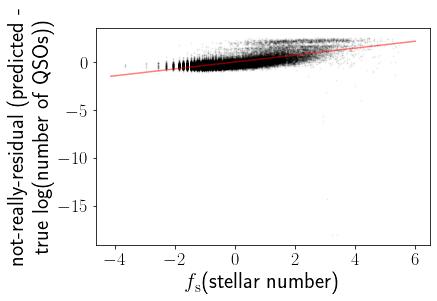

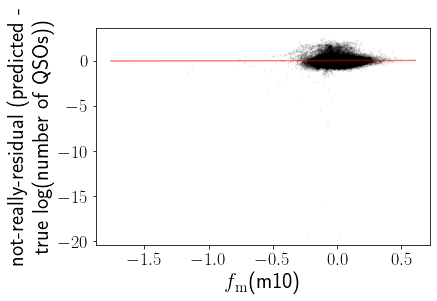

In [41]:
for j in range(1, X.shape[1]):
    plt.figure()
    plt.xlabel(feature_names[j])
    plt.ylabel(f'not-really-residual (predicted -\ntrue {label_name})')
    
    theta_dropout = theta.copy()
    theta_dropout[j] = 0 #brittle
    y_pred_dropout = calc_y_pred(X, theta_dropout)
    
    plt.scatter(X[:,j], y_pred_dropout-y, s=1, alpha=0.05, color='k', label='true')
    
    x_line = np.array(plt.xlim())
    y_line = -theta[j]*x_line
    plt.plot(x_line, y_line, 'r-', alpha=0.5)

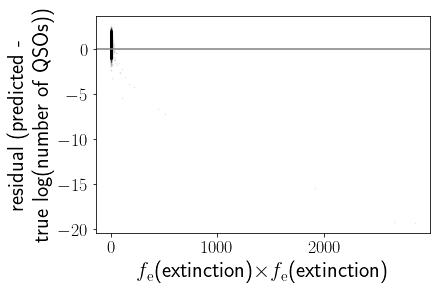

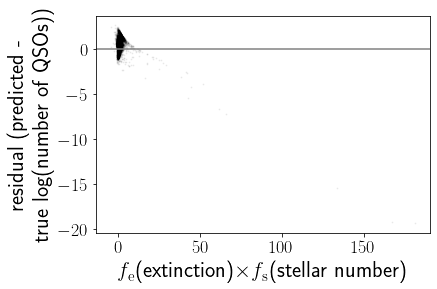

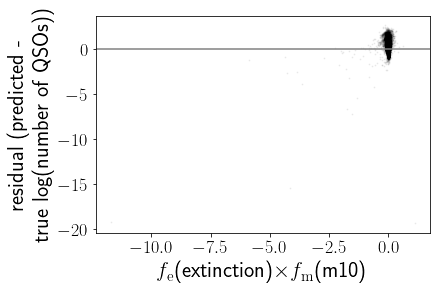

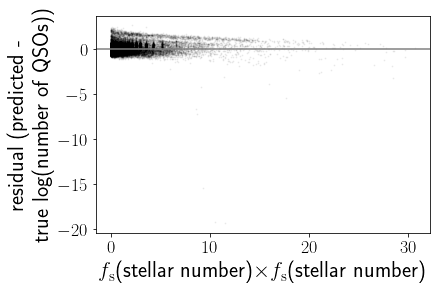

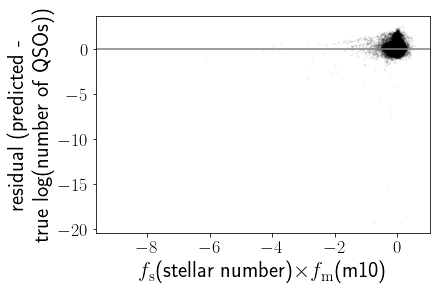

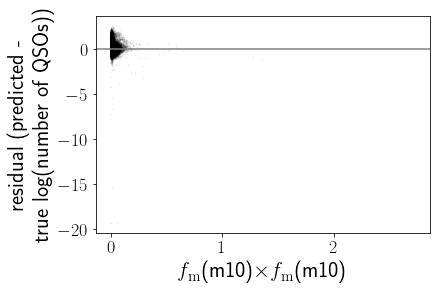

In [42]:
for i in range(1, X.shape[1]):
    for j in range(i, X.shape[1]):
        plt.figure()
        
        plt.scatter(X[:,i]*X[:,j], y_pred-y, s=1, alpha=0.05, color='k', label='true')
        plt.axhline(0, color='grey')
        plt.xlabel(feature_names[i]+r'$\times$'+feature_names[j])
        plt.ylabel(f'residual (predicted -\ntrue {label_name})')

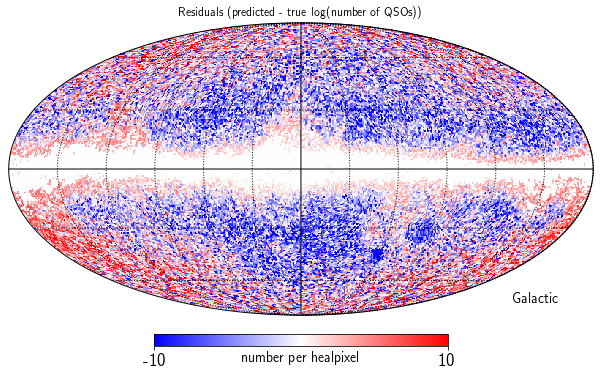

In [43]:
hp.mollview(y_pred_full_unscaled-map_nqso_data, title=rf"Residuals (predicted - true {label_name})",
            unit=r"number per healpixel", cmap='bwr', coord=['C', 'G'], min=-10, max=10)
hp.graticule()

In [44]:
print(np.mean(y_pred_full_unscaled))
print(np.mean((y_pred_full_unscaled-map_nqso_data)**2))

12.344889349023669
22.811538383820913


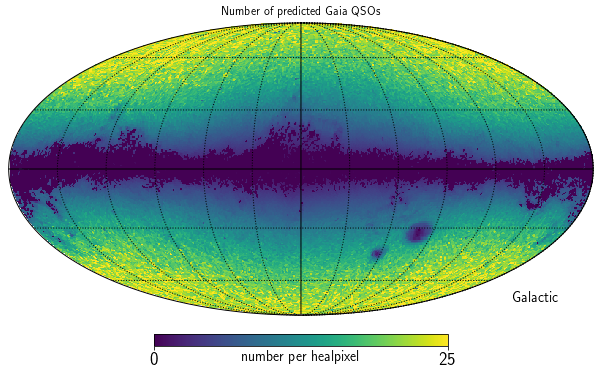

In [45]:
hp.mollview(y_pred_full_unscaled, title=rf"Number of predicted Gaia QSOs",
            unit=r"number per healpixel", cmap='viridis', coord=['C', 'G'], min=0, max=n_max_map)
hp.graticule()

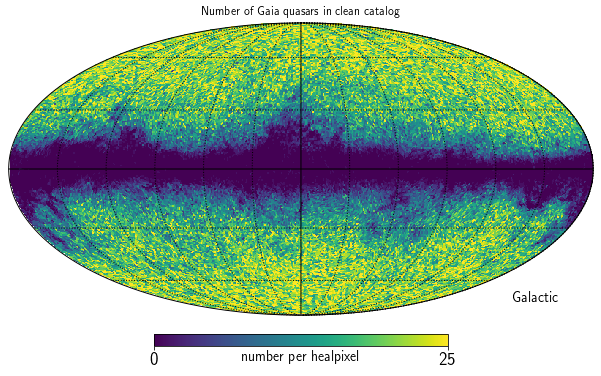

In [46]:
hp.mollview(map_nqso_data, title=rf"Number of Gaia quasars in clean catalog",
            unit=r"number per healpixel", cmap='viridis', coord=['C', 'G'], min=0, max=n_max_map)
hp.graticule()

# Make probability map for downsampling

In [47]:
nqso_clean = unscale_y(theta[0], scale_name=y_scale_name)
print(nqso_clean)

12.74567227716514


In [48]:
np.min(y_pred_full_unscaled), np.max(y_pred_full_unscaled)

(0.0, 53.280330478615085)

In [49]:
map_prob = y_pred_full_unscaled / nqso_clean

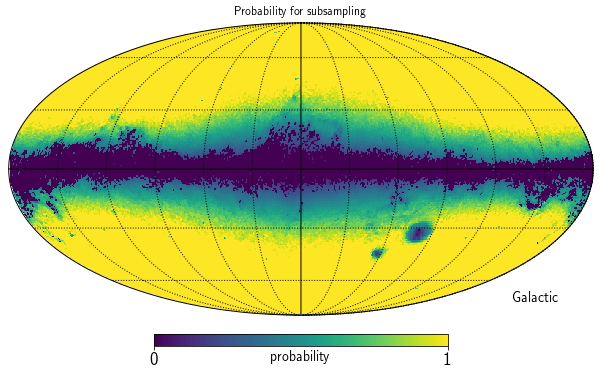

In [50]:
hp.mollview(map_prob, title=rf"Probability for subsampling",
            unit=r"probability", cmap='viridis', coord=['C', 'G'], min=0, max=1)
hp.graticule()

In [51]:
#fn_map_stardust_prob = f'../data/map/map_probability_dust_stars_m10_NSIDE{NSIDE}.fits'
#hp.write_map(fn_map_stardust_prob, map_stardust_prob)

# f it let's try a GP

In [52]:
import george

In [53]:
# assuming poisson error on number counts
if y_scale_name=='log':
    yerr = 1/np.sqrt(y_unscaled) 
else:
    yerr = np.clip(np.sqrt(y_unscaled), 1, None)

In [54]:
yerr.shape, X.shape

((42113,), (42113, 4))

In [55]:
ndim = X.shape[1]
kernel = george.kernels.ExpSquaredKernel(1.0, ndim=ndim)
gp = george.GP(kernel)
gp.compute(X, yerr)

In [56]:
y_pred_gp, pred_var = gp.predict(y, X, return_var=True)

In [57]:
y_pred_gp_unscaled = unscale_y(y_pred_gp, scale_name=y_scale_name)

In [58]:
y_pred_gp_full = np.zeros(y_full.shape)
y_pred_gp_full[idx_fit] = y_pred_gp

y_pred_gp_full_unscaled = np.zeros(y_full.shape)
y_pred_gp_full_unscaled[idx_fit] = y_pred_gp_unscaled

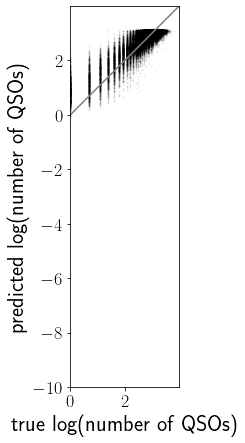

In [59]:
plt.figure(figsize=(7,7))
n_max = max(np.max(y), np.max(y_pred))
xx = np.linspace(0, n_max)
plt.plot(xx, xx, color='grey')
plt.scatter(y, y_pred_gp, s=1, alpha=0.05, color='k')
plt.xlim(0,n_max)
plt.ylim(-10,n_max)
plt.xlabel('true '+label_name)
plt.ylabel('predicted '+label_name)
ax = plt.gca()
ax.set_aspect('equal')

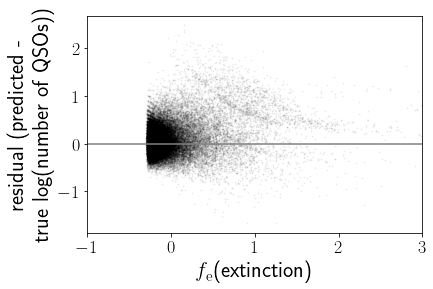

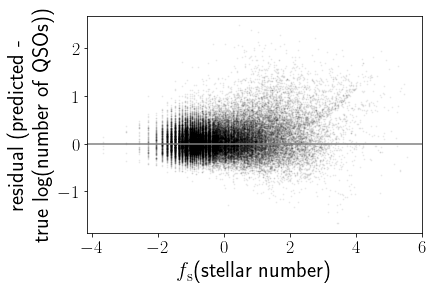

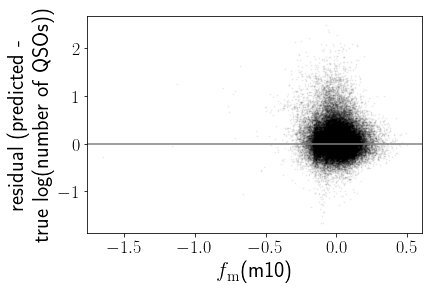

In [60]:
for j in range(1, X.shape[1]):
    plt.figure()
    plt.xlabel(feature_names[j])
    plt.ylabel(f'residual (predicted -\ntrue {label_name})')
    plt.axhline(0, color='grey')
    plt.scatter(X[:,j], y_pred_gp-y, s=1, alpha=0.05, color='k', label='true')
    if 'extinction' in feature_names[j]:
        plt.xlim(-1,3)

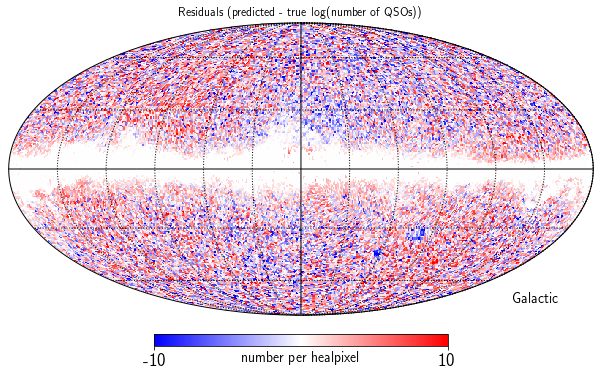

In [61]:
hp.mollview(y_pred_gp_full_unscaled-map_nqso_data, title=rf"Residuals (predicted - true {label_name})",
            unit=r"number per healpixel", cmap='bwr', coord=['C', 'G'], min=-10, max=10)
hp.graticule()

In [62]:
print(np.mean(y_pred_gp_full_unscaled))
print(np.mean((y_pred_gp_full_unscaled-map_nqso_data)**2))

13.675226080433974
14.476386267111062


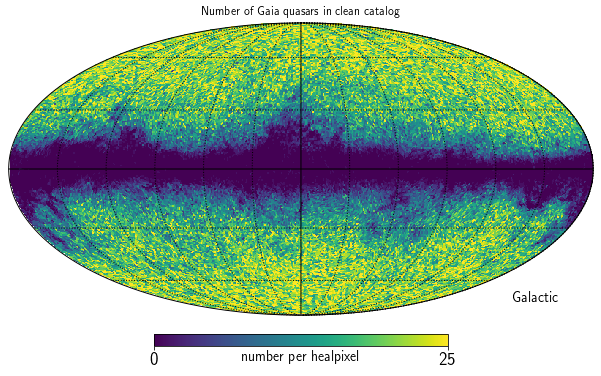

In [63]:
hp.mollview(map_nqso_data, title=rf"Number of Gaia quasars in clean catalog",
            unit=r"number per healpixel", cmap='viridis', coord=['C', 'G'], min=0, max=n_max_map)
hp.graticule()

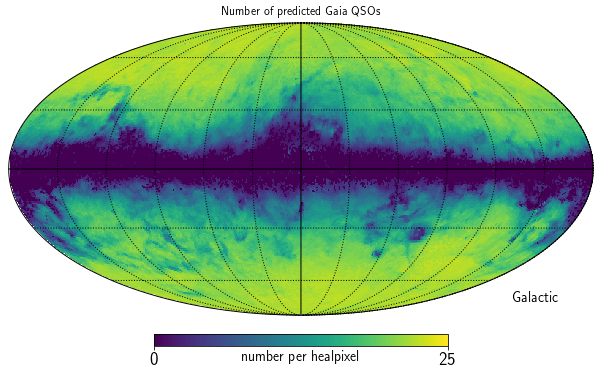

In [64]:
hp.mollview(y_pred_gp_full_unscaled, title=rf"Number of predicted Gaia QSOs",
            unit=r"number per healpixel", cmap='viridis', coord=['C', 'G'], min=0, max=n_max_map)
hp.graticule()

### Save as probability map

In [65]:
idx_clean = (map_dust < 0.03) & (map_stars < 15) & (map_m10 > 21)
print("Number of clean pixels:", np.sum(idx_clean), f"(Total: {NPIX})")
nqso_clean = np.mean(map_nqso_data[idx_clean])
print(nqso_clean)

Number of clean pixels: 301 (Total: 49152)
21.219269102990033


In [66]:
map_prob = y_pred_gp_full_unscaled / nqso_clean
map_prob[map_prob>1.0] = 1.0
print(np.min(map_prob), np.max(map_prob))

0.0 1.0


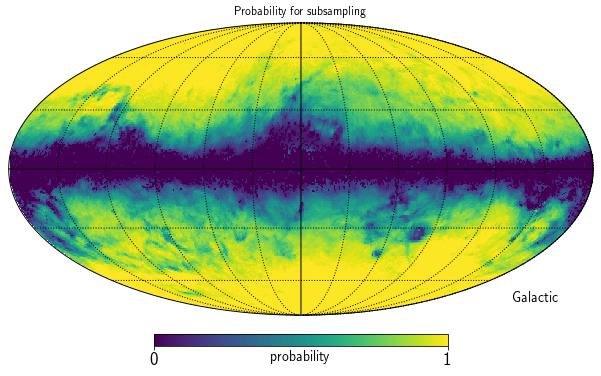

In [67]:
hp.mollview(map_prob, title=rf"Probability for subsampling",
            unit=r"probability", cmap='viridis', coord=['C', 'G'])#, min=0, max=1)
hp.graticule()

In [68]:
# fn_map_prob = f'../data/maps/map_probability_dust_stars_m10_NSIDE{NSIDE}_G{G_max}.fits'
# hp.write_map(fn_map_prob, map_prob)

# GP with mean scaling

In [69]:
idx_clean = (map_dust < 0.03) & (map_stars < 15) & (map_m10 > 21)
print("Number of clean pixels:", np.sum(idx_clean), f"(Total: {NPIX})")
nqso_mean_clean_regions = np.mean(map_nqso_data[idx_clean])
print(nqso_mean_clean_regions)

Number of clean pixels: 301 (Total: 49152)
21.219269102990033


In [70]:
len(idx_clean), len(idx_fit), len(y_unscaled), X.shape

(49152, 49152, 42113, (42113, 4))

In [71]:
yerr = 1/np.sqrt(y_unscaled) # assuming poisson error on number counts
yerr[idx_clean[idx_fit]] = 1/np.sqrt(N_data)

In [72]:
yerr.shape, X.shape

((42113,), (42113, 4))

In [73]:
mean = np.log(nqso_mean_clean_regions)

In [74]:
ndim = X.shape[1]
kernel = george.kernels.ExpSquaredKernel(1.0, ndim=ndim)
gp = george.GP(kernel, mean=mean)
gp.compute(X, yerr)

In [75]:
y_pred_gp, pred_var = gp.predict(y, X, return_var=True)

In [76]:
y_pred_gp_unscaled = unscale_y(y_pred_gp, scale_name=y_scale_name)

In [77]:
y_pred_gp_full = np.zeros(y_full.shape)
y_pred_gp_full[idx_fit] = y_pred_gp

y_pred_gp_full_unscaled = np.zeros(y_full.shape)
y_pred_gp_full_unscaled[idx_fit] = y_pred_gp_unscaled

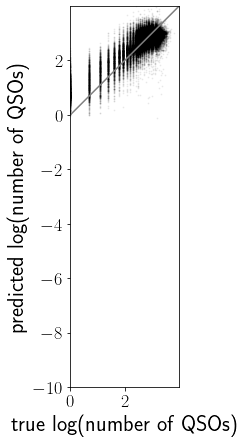

In [78]:
plt.figure(figsize=(7,7))
n_max = max(np.max(y), np.max(y_pred))
xx = np.linspace(0, n_max)
plt.plot(xx, xx, color='grey')
plt.scatter(y, y_pred_gp, s=1, alpha=0.05, color='k')
plt.xlim(0,n_max)
plt.ylim(-10,n_max)
plt.xlabel('true '+label_name)
plt.ylabel('predicted '+label_name)
ax = plt.gca()
ax.set_aspect('equal')

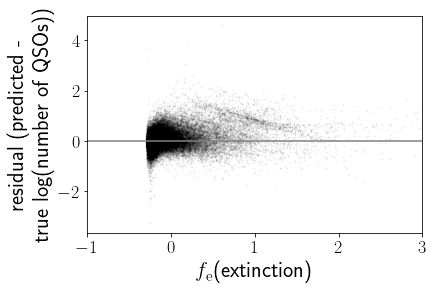

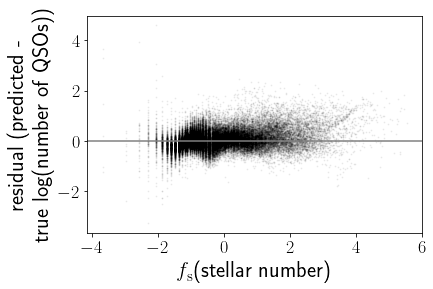

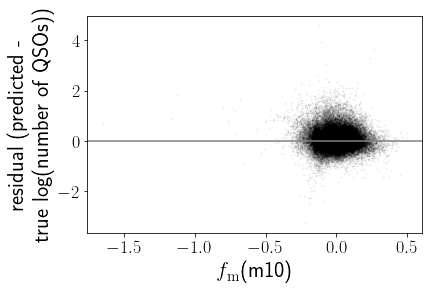

In [79]:
for j in range(1, X.shape[1]):
    plt.figure()
    plt.xlabel(feature_names[j])
    plt.ylabel(f'residual (predicted -\ntrue {label_name})')
    plt.axhline(0, color='grey')
    plt.scatter(X[:,j], y_pred_gp-y, s=1, alpha=0.05, color='k', label='true')
    if 'extinction' in feature_names[j]:
        plt.xlim(-1,3)

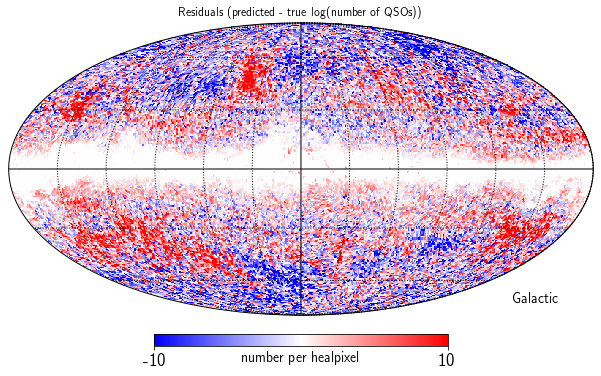

In [80]:
hp.mollview(y_pred_gp_full_unscaled-map_nqso_data, title=rf"Residuals (predicted - true {label_name})",
            unit=r"number per healpixel", cmap='bwr', coord=['C', 'G'], min=-10, max=10)
hp.graticule()

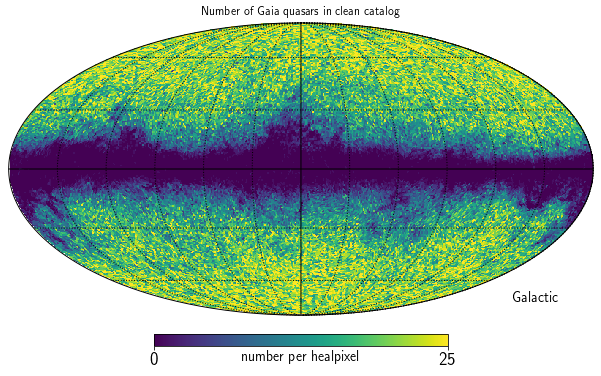

In [81]:
hp.mollview(map_nqso_data, title=rf"Number of Gaia quasars in clean catalog",
            unit=r"number per healpixel", cmap='viridis', coord=['C', 'G'], min=0, max=n_max_map)
hp.graticule()

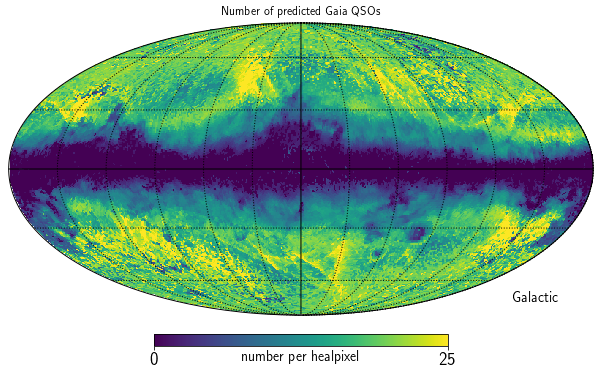

In [82]:
hp.mollview(y_pred_gp_full_unscaled, title=rf"Number of predicted Gaia QSOs",
            unit=r"number per healpixel", cmap='viridis', coord=['C', 'G'], min=0, max=n_max_map)
hp.graticule()